In [2]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
colors = sns.color_palette("tab10")

from MIPT import xi

from scipy.optimize import curve_fit

In [3]:
Ls = 2**np.arange(4, 10)
shots = 16
timesteps = 256
p_dict = {
    1: 0.15967,
    2: 0.32865,
    3: 0.416,
    4: 0.458,
    5: 0.4792
}
D = 2
p = p_dict[D]

In [4]:
# Load data. Rows are xi, y_mu, y_std
data_list = [np.zeros((3, L // 2)) for L in Ls]
logxdata = np.array([])
ydata = np.array([])
stddata = np.array([])
for i, L in enumerate(Ls):
    depth = L // 2
    try:
        filename = "data/{}_{}_{}_{}_{}_entropies_all.npy".format(L, depth, shots * timesteps, p, D)
        data_list[i][0, :] = np.array([xi(L, 0, i) for i in range(1, L // 2 + 1)])
        data_list[i][1:, :] = np.load(filename)
        if i >= 3: # L is 128, 256, or 512
            logxdata = np.log(data_list[i][0, :])
            ydata = data_list[i][1, :]
            stddata = data_list[i][2, :]
    except:
        print("No data for L = {}".format(L))
        t = int(np.log2(L) - 4 + 6 * (D - 1) + 1)
        with open("logs/slurm-28249642_{}.out".format(t), "r") as filename:
            print(filename.read())
        data_list.pop()
        Ls = Ls[:-1]

In [5]:
def S(xilog, h, c):
    return -h * xilog + c
start = logxdata.shape[0] // 8
end = 7 * logxdata.shape[0] // 8
fit_result = curve_fit(S, logxdata[start:end], ydata[start:end], p0 = [0.5, 1], sigma = stddata[start:end])
h = fit_result[0][0]
c = fit_result[0][1]

In [8]:
def S2(xilog, c):
    return -0.53 * xilog + c
start = logxdata.shape[0] // 8
end = 7 * logxdata.shape[0] // 8
fit_result = curve_fit(S2, logxdata[start:end], ydata[start:end], p0 = [1], sigma = stddata[start:end])
h = 0.53
c = fit_result[0][0]

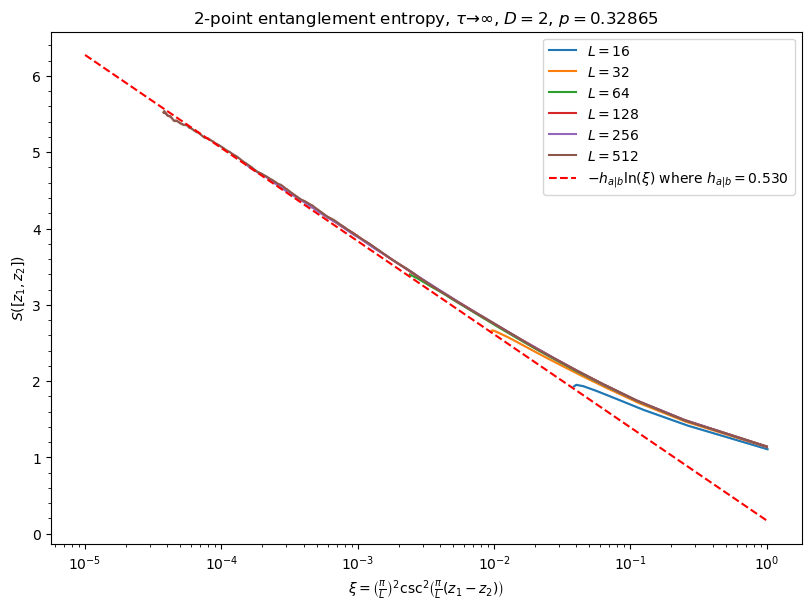

In [9]:
plt.subplots(figsize = (8, 6), layout = "constrained")

filename = "figs/{}_{}_entropies.png".format(D, p)

for i, L in enumerate(Ls):
    data = data_list[i]
    x = data[0, :]
    mu = data[1, :]
    std = data[2, :]
    plt.plot(x, mu, label = "$L={}$".format(L), color = colors[i])
    plt.fill_between(x, mu - std, mu + std, color = colors[i], alpha = 0.3)

xis = np.logspace(-5, 0, 1000)
Sxis = -h * np.log(xis) + c
plt.plot(xis, Sxis, linestyle = "--", color = "red", label = "$-h_{{a|b}}\ln(\\xi)$ where $h_{{a|b}}={:.3f}$".format(h))

plt.xlabel(r"$\xi=\left(\frac{\pi}{L}\right)^2\csc^2\left(\frac{\pi}{L}(z_1-z_2)\right)$")
plt.ylabel(r"$S([z_1,z_2])$")
plt.title("2-point entanglement entropy, $\\tau\\to\infty$, $D={}$, $p={}$".format(D, p))
plt.legend(loc = "upper right")
plt.xscale('log')
plt.minorticks_on()
plt.savefig(filename, dpi = 300)